# Jupyter Notebook for NumBAT 

This notebook demonstrates basic use of NumBAT within the Jupyter environment.

### Make some standard inputs.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import glob
import numpy as np

In [2]:
sys.path.append("../backend/")  # or whereever you have NumBAT installed
import materials
import objects
import mode_calcs
import integration
import plotting
from fortran import NumBAT


### Specify the geometry

In [3]:
wl_nm = 1550
unitcell_x = 5*wl_nm
unitcell_y = unitcell_x
inc_a_x = 550
inc_a_y = inc_a_x
inc_shape = 'circular'

num_modes_EM_pump = 20
num_modes_EM_Stokes = num_modes_EM_pump
num_modes_AC = 40
EM_ival_pump = 0
EM_ival_Stokes = 0
AC_ival = 'All'


### Make the structure

In [4]:
mat_bkg = materials.make_material("Vacuum")
mat_a   = materials.make_material("SiO2_2016_Smith")
                          
        
wguide = objects.Structure(unitcell_x,inc_a_x,unitcell_y,inc_a_y,inc_shape,
                          material_bkg=mat_bkg, material_a=mat_a,
                          lc_bkg=.1, lc_refine_1=10, lc_refine_2=10)

Building mesh


### Calculate the EM modes

In [ ]:
neff_est = 1.4

sim_EM_pump = wguide.calc_EM_modes(num_modes_EM_pump, wl_nm, n_eff=neff_est)

Find the backward Stokes fields

In [6]:
sim_EM_Stokes = mode_calcs.bkwd_Stokes_modes(sim_EM_pump)

### Generate EM mode fields

We are now ready to plot EM field profiles, but how many should we ask for?

The $V$-number of this waveguide can be estimated as $V=\frac{2 \pi a}{\lambda} \sqrt{n_c^2-n_{cl}^2}$:

In [7]:
V=2 *pi/wl_nm * inc_a_x * np.sqrt(np.real(mat_a.refindex_n**2 
                                  - mat_bkg.refindex_n**2))
print('V={0:.4f}'.format(V))

V=2.3410


We thus expect only a couple of guided modes and to save time and disk space, only ask for the first few to be generated:

In [10]:
prefix = 'tut_15'

plotting.plot_mode_fields(sim_EM_pump, EM_AC='EM_E',
        xlim_min=0.2, xlim_max=0.2, ylim_min=0.2, ylim_max=0.2,
        prefix=prefix, ivals=range(5))



  Structure has raw domain(x,y)   = [-3.87500, 3.87500] x [ -3.87500, 3.87500] (um), 
                mapped to (x',y') = [-3.87500, 3.87500] x [ -3.87500, 3.87500] (um)
                    
Plotting em modes m=0 to 4.


Get a list of the generated files. By sorting the list, the modes will be in order from lowest ($m=0$) to highest.

In [11]:
emfields = glob.glob(prefix_str+'-fields/EM*.png')
emfields.sort()

In Jupyter, we can display images using the `display(Image(filename=f))` construct.



 tut_15-fields/EM_E_field_00.png


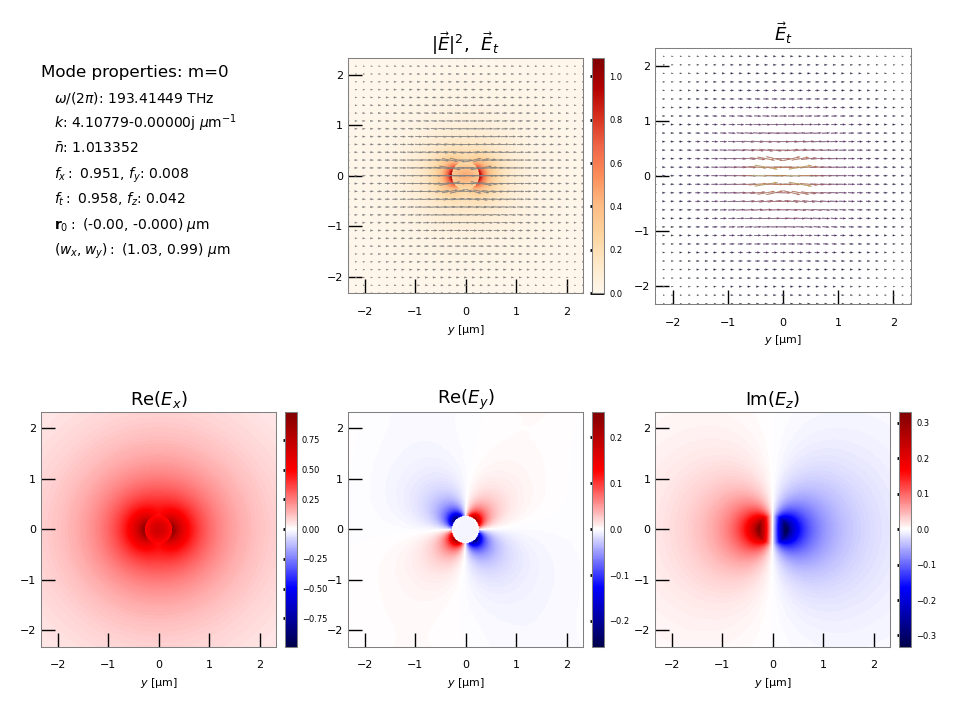



 tut_15-fields/EM_E_field_01.png


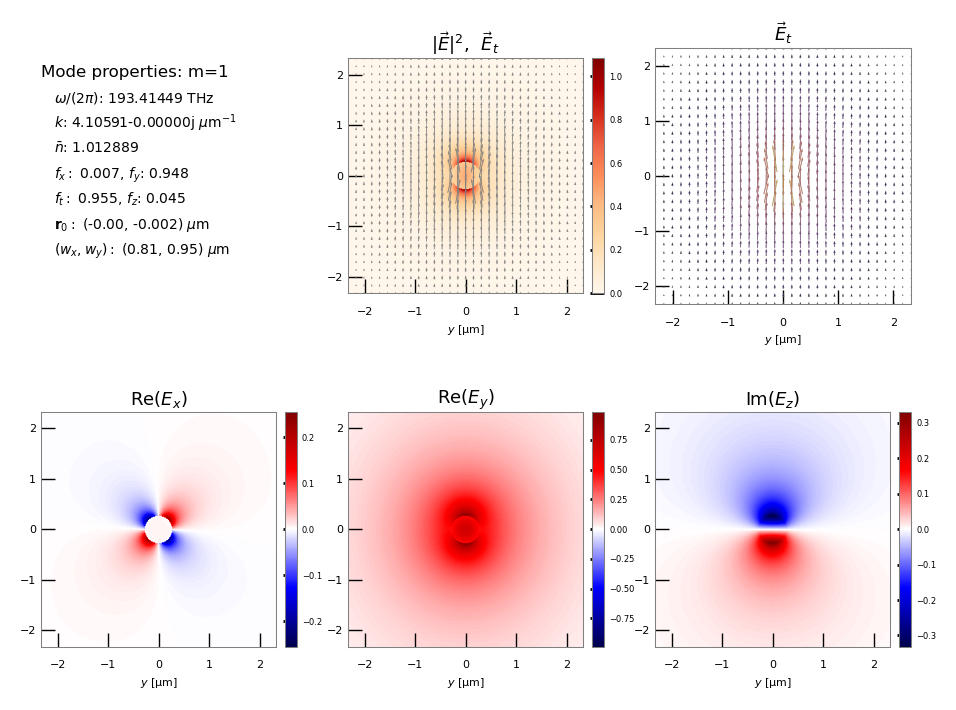



 tut_15-fields/EM_E_field_02.png


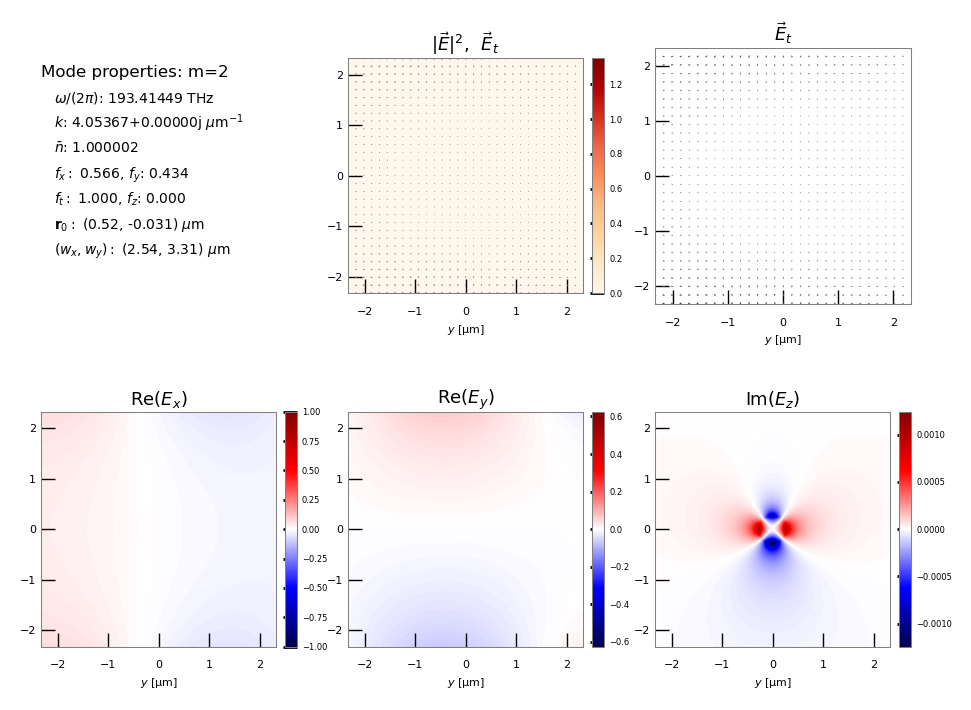

In [12]:
for f in emfields[0:3]:
    print('\n\n',f)
    display(Image(filename=f))

### Calculate the acoustic modes

Now let's turn to the acoustic modes.

For backwards SBS, we set the desired acoustic wavenumber to the difference between the pump and Stokes wavenumbers.
        $\Omega$
    We specify a 'shift' frequency as a starting location of the frequency to look for solutions 

In [13]:
q_AC = np.real(sim_EM_pump.kz_EM(EM_ival_pump) - sim_EM_Stokes.kz_EM(EM_ival_Stokes))

NuShift_Hz = 4e9

sim_AC = wguide.calc_AC_modes(num_modes_AC, q_AC, EM_sim=sim_EM_pump, shift_Hz=NuShift_Hz)


nlist [1.  +0.j 1.45+0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j
 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j 1.  +0.j
 1.  +0.j 1.  +0.j 1.  +0.j]


Calculating AC modes

 Structure has 273 mesh points and 124 mesh elements.

 -----------------------------------------------
 AC FEM: 
       - assembling linear system
           cpu time  =   0.00 secs.
           wall time =   0.00 secs.
       - solving linear system
           cpu time  =   1.39 secs.
           wall time =   0.26 secs.
 -----------------------------------------------



In [16]:
plotting.plot_mode_fields(sim_AC, prefix=prefix, ivals=range(10))

Plotting acoustic modes m=0 to 9.


In [17]:
acfields = glob.glob(prefix+'-fields/AC*.png')
acfields.sort()




 tut_15-fields/AC_field_00.png


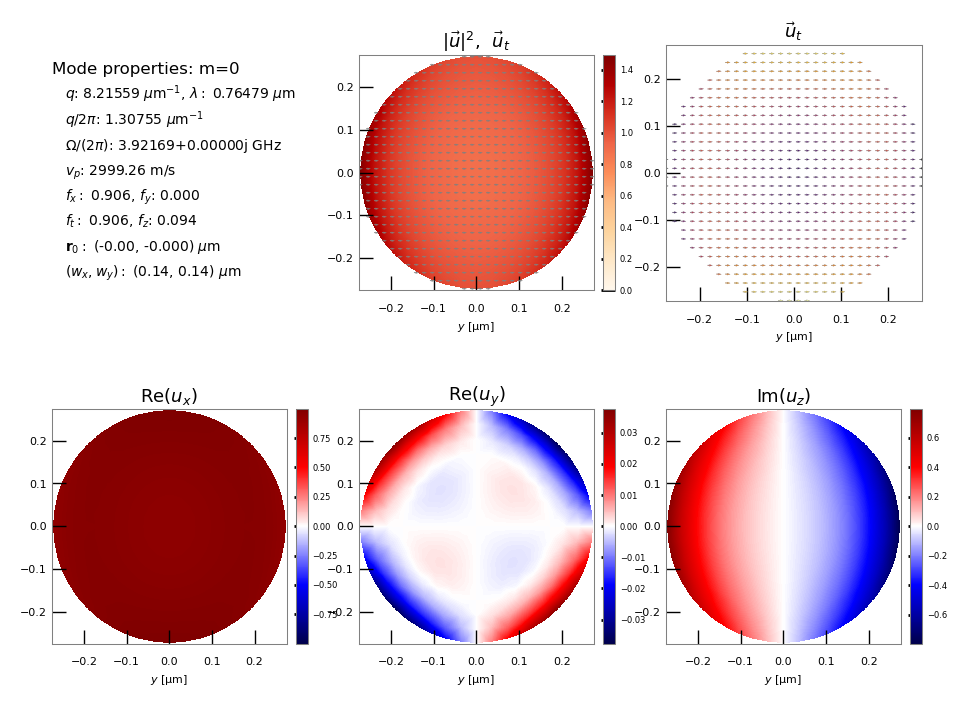



 tut_15-fields/AC_field_01.png


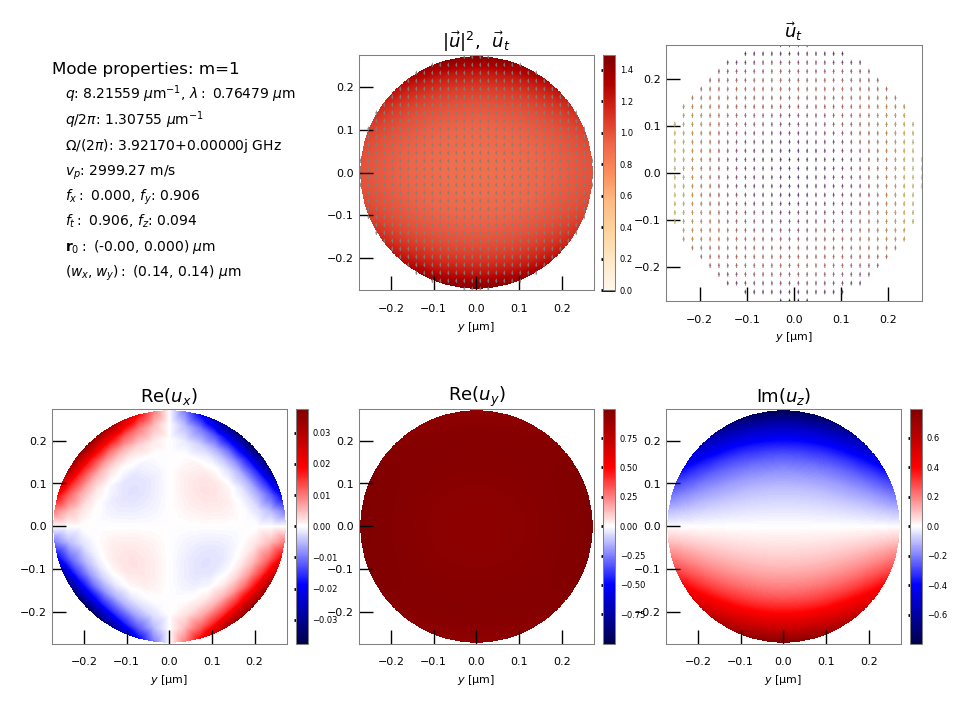



 tut_15-fields/AC_field_02.png


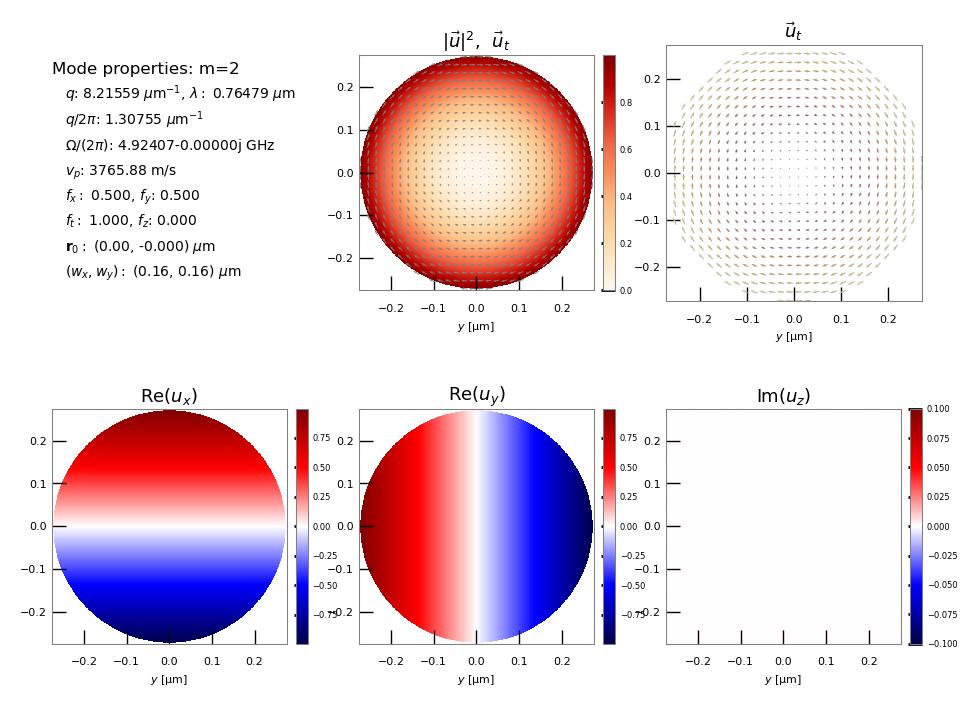



 tut_15-fields/AC_field_03.png


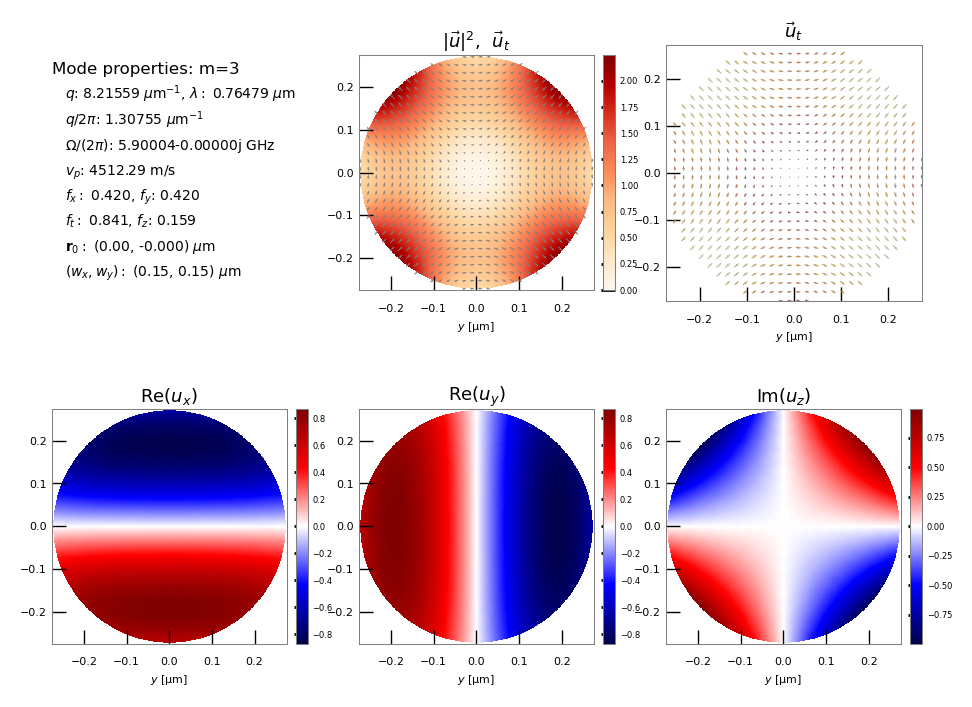



 tut_15-fields/AC_field_04.png


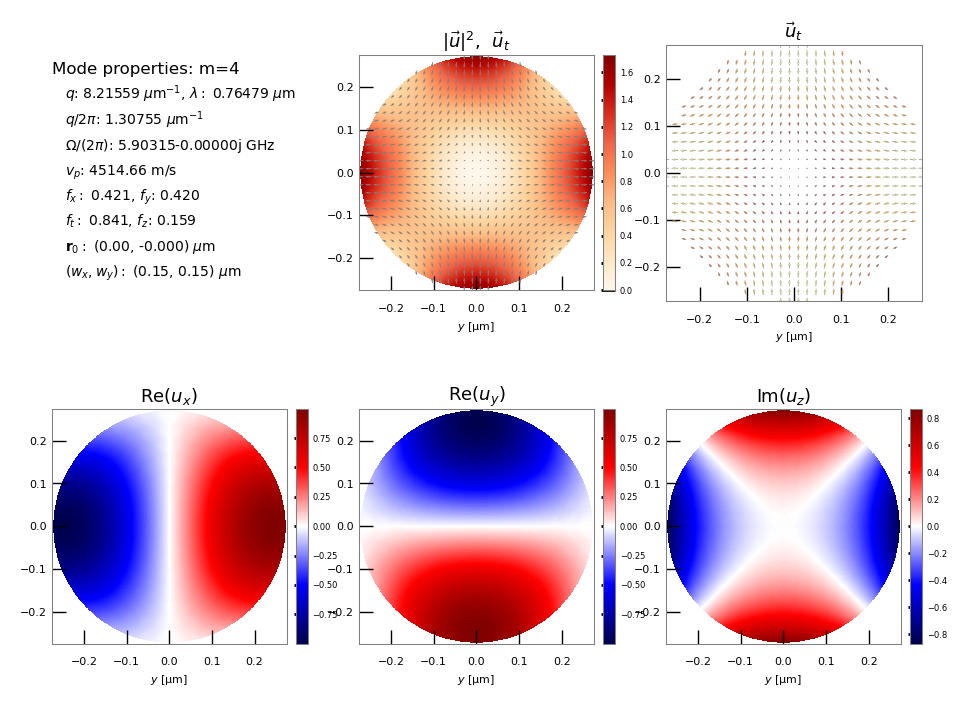



 tut_15-fields/AC_field_05.png


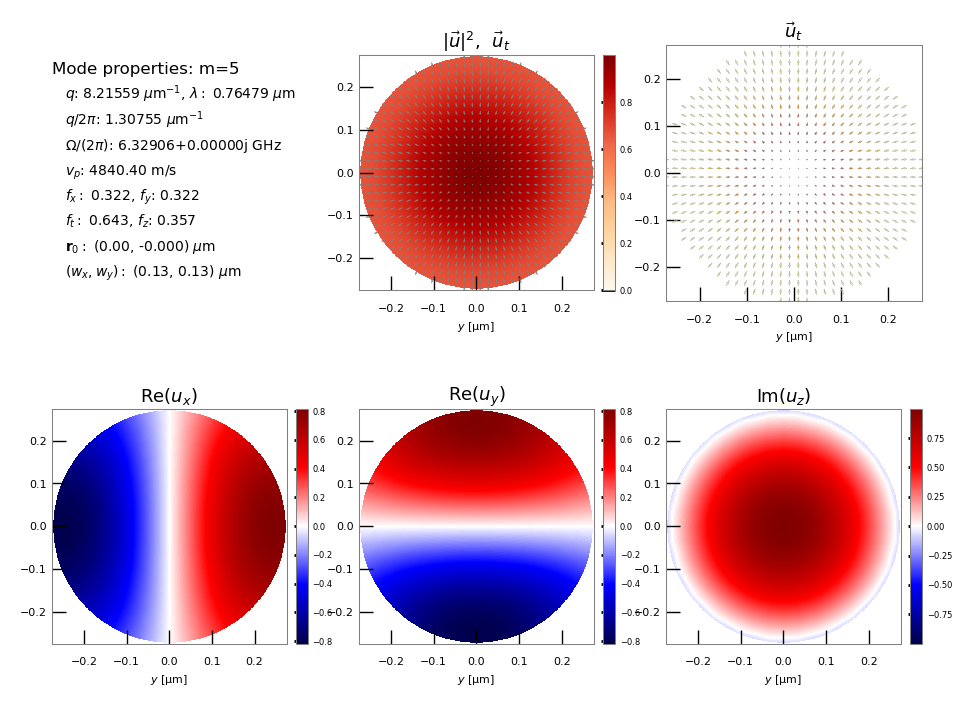

In [19]:
for f in acfields[0:6]:
    print('\n\n',f)
    display(Image(filename=f))